1. Implement Oja's rule, Sanger's rule, Foldiak's rule and BCM rule on MNIST
2. Compare using linear, Relu, Sigmoid, tanh activation function

In [1]:
# Import libraries
# Import libraries
%reset -f
%reload_ext autoreload

# %load BCM_running.py

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import argparse
import seaborn as sns
%matplotlib inline
from local_lr import data_loader
from local_lr import BCM_cl
from local_lr import BCM_fully_connect_cl as BCM
# Reset tf.app.flags.FLAGS

from tensorflow.python.framework import ops
ops.reset_default_graph()

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

In [2]:
# Load dataset
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('/tmp/data')

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
X_train = mnist.train.images
X_train = X_train[:1000,:]
X_label = mnist.train.labels[:1000]

from sklearn.preprocessing import StandardScaler

demeaner = StandardScaler(with_std=False)
X_train_demean = demeaner.fit_transform(X_train)

zcamatrix = data_loader.zca_whitening_matrix(X_train_demean.T)
X_train_whiten = X_train.dot(zcamatrix)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


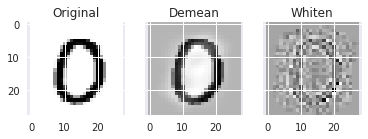

In [4]:
emp_idx = 10

fig, axes = plt.subplots(1,3,sharex=True, sharey=True)
fig.set_figheight(1.7)
fig.set_figwidth(6)
train_emp = X_train[emp_idx,:]
axes[0].imshow(train_emp.reshape(28,28), cmap="Greys")
axes[0].set_title('Original')

train_demean_emp = X_train_demean[emp_idx,:]
axes[1].imshow(train_demean_emp.reshape(28,28), cmap="Greys")
axes[1].set_title('Demean')

train_whiten_emp = X_train_whiten[emp_idx,:]
axes[2].imshow(train_whiten_emp.reshape(28,28), cmap="Greys")
axes[2].set_title('Whiten')

In [5]:
# Obtain PCA components
n_components = 5

pca = PCA(n_components=n_components)
ica = FastICA(n_components=n_components)
data_map=(X_train, X_train_demean, X_train_whiten)

PC={}
IC={}
for i in range(3):
    data = data_map[i]
    pca.fit(data_map[i])
    PC[i] = pca.components_
    ica.fit(data_map[i])     
    IC[i] = ica.components_

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


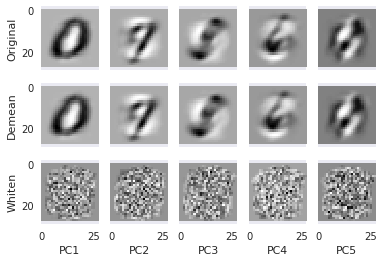

In [6]:
# Plot the PCA weights
fig, axes = plt.subplots(3,n_components,sharex=True, sharey=True)
prepro_type = ['Original', 'Demean', 'Whiten']

for i in range(3):
    PC_plot = PC[i]
    axes[i][0].set_ylabel(prepro_type[i])
    for j in range(n_components):
        plt_emp = PC[i][j,:].reshape(28, 28)
        axes[i][j].imshow(plt_emp, cmap="Greys")
        axes[i][j].grid(False)
        axes[2][j].set_xlabel('PC{}'.format(j+1))

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


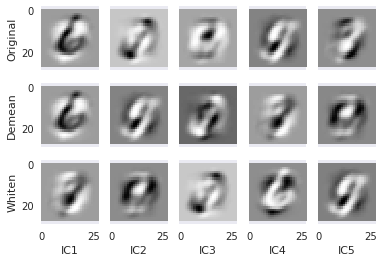

In [7]:
# Plot the ICA weights
fig, axes = plt.subplots(3,n_components,sharex=True, sharey=True)
prepro_type = ['Original', 'Demean', 'Whiten']

for i in range(3):
    IC_plot = IC[i]
    axes[i][0].set_ylabel(prepro_type[i])
    for j in range(n_components):
        plt_emp = IC[i][j,:].reshape(28, 28)
        axes[i][j].imshow(plt_emp, cmap="Greys")
        axes[i][j].grid(False)
        axes[2][j].set_xlabel('IC{}'.format(j+1))

In [40]:
# Train with Oja's learning rule, plot the trajectory
from local_lr import Oja_cl

learning_rate = 0.00001
epoch = 2000
np.random.seed(1)
n_input = 784
n_output = 2
w_init = np.random.randn(n_input, n_output)
nonlinear= [None, 'relu', 'sigmoid', 'tanh']

kwarg = {}
w_track = {}
w_final = {}
for i in range(len(nonlinear)):
    w_track_tmp = []
    oja_fw, oja_up = Oja_cl.oja(eta=learning_rate, act=nonlinear[i])
    kwarg['w'] = w_init
    for j in range(epoch):
        w_track_tmp.append(kwarg['w'].reshape(-1,1))
        y = oja_fw(X_train_demean, **kwarg)
        kwarg = oja_up(X_train_demean, y, **kwarg)
    w_track[nonlinear[i]] = w_track_tmp
    w_final[nonlinear[i]] = kwarg['w']

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


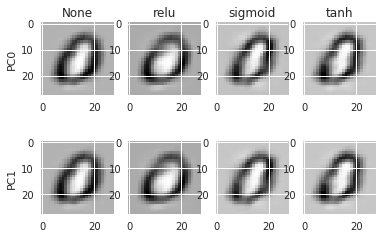

In [41]:
fig, axes = plt.subplots(n_output, len(nonlinear), )

for i in range(n_output):
    axes[i][0].set_ylabel('PC{}'.format(i))
    for j in range(len(nonlinear)):
        axes[i][j].imshow(w_final[nonlinear[j]][:,i].reshape(28,28))
        axes[0][j].set_title(nonlinear[j])

From the training exprience we realized that low learining rate is important for training with Oja's rule.

In [44]:
# Train with Foldiaks's learning rule, plot the trajectory
from local_lr import Foldiak_cl

learning_rate = 0.00001
epoch = 1000
np.random.seed(10)
n_input = 784
n_output = 5
w_init = np.random.randn(n_input, n_output)
q_init = -1 * np.tril(np.random.rand(n_output,n_output), -1)
nonlinear= [None, 'relu', 'sigmoid', 'tanh']

kwarg = {}
w_track = {}
w_final = {}
for i in range(len(nonlinear)):
    w_track_tmp = []
    foldiak_fw, foldiak_up = Foldiak_cl.foldiak(eta=learning_rate, act=nonlinear[i])
    kwarg['w'] = w_init
    kwarg['q'] = q_init
    for j in range(epoch):
        w_track_tmp.append(kwarg['w'].reshape(-1,1))
        y = foldiak_fw(X_train_demean, **kwarg)
        kwarg = foldiak_up(X_train_demean, y, **kwarg)
    w_track[nonlinear[i]] = w_track_tmp
    w_final[nonlinear[i]] = kwarg['w']

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


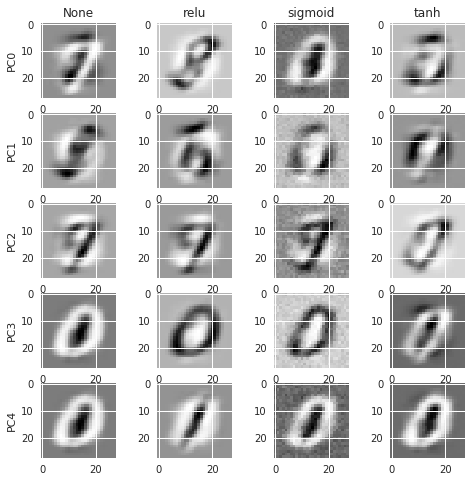

In [46]:
fig, axes = plt.subplots(n_output, len(nonlinear), )
fig.set_figwidth(8)
fig.set_figheight(8)

for i in range(n_output):
    axes[i][0].set_ylabel('PC{}'.format(i))
    for j in range(len(nonlinear)):
        axes[i][j].imshow(w_final[nonlinear[j]][:,i].reshape(28,28))
        axes[0][j].set_title(nonlinear[j])

Given that QBCM rule with sigmoid and tanh function fails to train, we will only look carefully into None and relu activation function. Moreover, it is more stable to train on demeaned inputs, instead of whitened inputs.

In [76]:
# Training results BCM rule + linear
# Apply l2 normalization

from local_lr import QBCM_cl
from sklearn.preprocessing import normalize

batch_size = 10
learning_rate = 0.0001/batch_size
decay_const = 0.0002/learning_rate
epoch = 10
np.random.seed(1)
n_input = 784
n_output = 20
w_init = np.random.randn(n_input, n_output)
thres_init = np.zeros((1, n_output))
nonlinear= ['relu']

kwarg = {}
w_track = {}
w_final = {}
for i in range(len(nonlinear)):
    w_track_tmp = []
    qbcm_fw, qbcm_up = QBCM_cl.qbcm(eta=learning_rate, act=nonlinear[i], batch_size=batch_size, decay=decay_const)
    kwarg['w'] = w_init
    kwarg['thres'] = thres_init
    for j in range(epoch):
        w_track_tmp.append(kwarg['w'].reshape(-1,1))
        # Apply wegitht normalization
        kwarg = qbcm_up(X_train_demean, **kwarg)
        
    w_track[nonlinear[i]] = w_track_tmp
    w_final[nonlinear[i]] = kwarg['w']

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


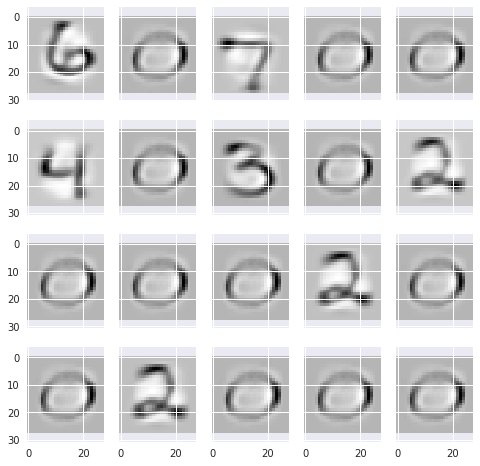

In [77]:
n_row = 4
n_col = 5
fig, axes = plt.subplots(n_row, n_col, sharex=True, sharey=True)
fig.set_figwidth(8)
fig.set_figheight(8)

for i in range(n_row):
    for j in range(n_col):
        axes[i][j].imshow(w_final['relu'][:,i * n_col + j].reshape(28,28))

In [25]:
# Training results QBCM rule + relu
# Apply l2 normalization
# With foldiak lateral inhibition

from local_lr import QBCM_foldiak

batch_size = 1
learning_rate = 0.0001
decay_const = 2
epoch = 100
inhi_strength = 0.05
np.random.seed(1)
n_input = 784
n_output = 20
w_init = np.random.randn(n_input, n_output)
q_init = -1 * np.tril(np.random.rand(n_output,n_output), -1)
thres_init = np.zeros((1, n_output))
nonlinear= ['relu']

kwarg = {}
w_track = {}
w_final = {}
for i in range(len(nonlinear)):
    w_track_tmp = []
    qbcmf_fw, qbcmf_up = QBCM_foldiak.qbcm_foldiak(eta=learning_rate, act=nonlinear[i], batch_size=batch_size, decay=decay_const, inhi_strength=inhi_strength)
    kwarg['w'] = w_init
    kwarg['thres'] = thres_init
    kwarg['q'] = q_init
    for j in range(epoch):
        w_track_tmp.append(kwarg['w'].reshape(-1,1))
        kwarg = qbcmf_up(X_train_demean, **kwarg)
        
    w_track[nonlinear[i]] = w_track_tmp
    w_final[nonlinear[i]] = kwarg['w']

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


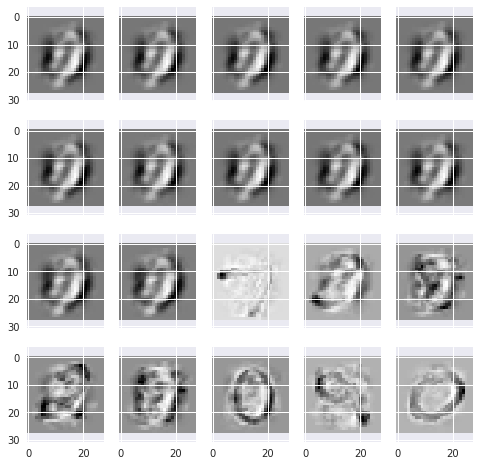

In [26]:
n_row = 4
n_col = 5
fig, axes = plt.subplots(n_row, n_col, sharex=True, sharey=True)
fig.set_figwidth(8)
fig.set_figheight(8)

for i in range(n_row):
    for j in range(n_col):
        axes[i][j].imshow(w_final['relu'][:,i * n_col + j].reshape(28,28))

In [27]:
kwarg['q'].shape

(20, 20)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


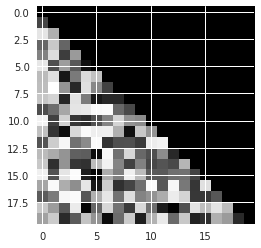

In [28]:
plt.imshow(kwarg['q'], cmap='Greys')